In [1]:
"""
UDA Final Project - Vijay Mayadas
CID-02270048
Date - 01/01/2024
I have worked independently
Code references are captured in the PDF report
The following code is built on the examples gievn in Refs [8, 9, 10] as described in the report
"""

'\nUDA Final Project - Vijay Mayadas\nCID-02270048\nDate - 01/01/2024\nI have worked independently\nCode references are captured in the PDF report\nThe following code is built on the examples gievn in Refs [8, 9, 10] as described in the report\n'

In [2]:
# Importing the libraries

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import time
import copy
import torch
import warnings
import seaborn as sns

from torch_geometric.datasets import EllipticBitcoinDataset
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

np.random.seed(30224)
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset

def load_elliptic_bitcoin_dataset():
    path = os.getcwd()  # get current directory
    dataset = EllipticBitcoinDataset(root=path)
    return dataset

elliptic_dataset = load_elliptic_bitcoin_dataset()


In [4]:
# Create a dataframe for each of the three files from the dataset

df_classes = pd.read_csv("raw/elliptic_txs_classes.csv")
df_edges = pd.read_csv("raw/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("raw/elliptic_txs_features.csv", header=None)

In [5]:
# Rename the columns of the features dataframe

colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

In [6]:
# Show the first few rows of the features dataframe

df_features = df_features.rename(columns=colNames)
df_features.head()

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [7]:
# Replace the 'unknown' class with '3' in the classes dataframe and show the shape of the three dataframes

df_classes.loc[df_classes['class'] == 'unknown', 'class'] = '3'
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


In [8]:
# Merge the classes and features into a single dataframe df

df = df_classes.merge(df_features, how='left', left_on='txId', right_on='txId')

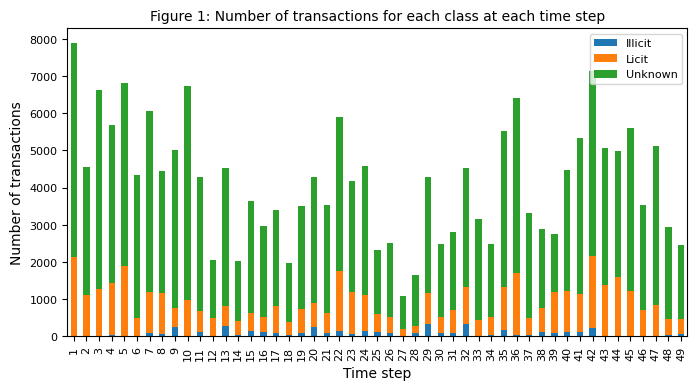

In [9]:
# This code snippet creates Figure 1 in the report that shows the distribution of the transaction types at each time step

# Convert 'class' column to string
df['class'] = df['class'].astype(str)

# Define a dictionary mapping the old class labels to the new ones for the visualization
class_dict = {'1': 'Illicit', '2': 'Licit', '3': 'Unknown'}

# Replace the class labels in the DataFrame
df['class'] = df['class'].replace(class_dict)

# Group by 'Time step' and 'class', count the number of transactions, unstack 'class'
grouped = df.groupby(['Time step', 'class']).size().unstack(fill_value=0)

# Plot
grouped.plot(kind='bar', stacked=True, figsize=(8,4))

plt.title('Figure 1: Number of transactions for each class at each time step', fontsize=10)
plt.xlabel('Time step', fontsize=10)
plt.ylabel('Number of transactions', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.legend(loc='upper right', fontsize=8)
plt.show()

In [10]:
# Merge class and features for pre-processing

df_class_feature = pd.merge(df_classes, df_features )
df_class_feature.head()

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


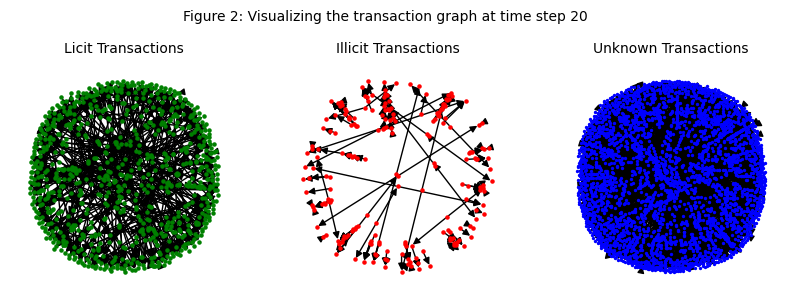

In [11]:
# This code creates Figure 2 that helps visualize the transaction graph at a given time step for the three classes

plt.figure(figsize=(10, 3))

plt.suptitle('Figure 2: Visualizing the transaction graph at time step 20', fontsize=10, y=1.05)

# Visualize just the licit transactions
licit_ids = df_class_feature.loc[(df_class_feature['Time step'] == 20) & (df_class_feature['class'] == '2'), 'txId']
licit_edges = df_edges.loc[df_edges['txId1'].isin(licit_ids)]
graph = nx.from_pandas_edgelist(licit_edges, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot number 1
nx.draw(graph, with_labels=False, node_size=5, node_color='green')
plt.title('Licit Transactions', fontsize=10)

# Visualize just the illicit transactions
illicit_ids = df_class_feature.loc[(df_class_feature['Time step'] == 20) & (df_class_feature['class'] == '1'), 'txId']
illicit_edges = df_edges.loc[df_edges['txId1'].isin(illicit_ids)]
graph = nx.from_pandas_edgelist(illicit_edges, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())
plt.subplot(1, 3, 2)  # 1 row, 3 columns, plot number 2
nx.draw(graph, with_labels=False, node_size=5, node_color='red')
plt.title('Illicit Transactions', fontsize=10)

# Visualize just the unknown transactions
unknown_ids = df_class_feature.loc[(df_class_feature['Time step'] == 20) & (df_class_feature['class'] == '3'), 'txId']
unknown_edges = df_edges.loc[df_edges['txId1'].isin(unknown_ids)]
graph = nx.from_pandas_edgelist(unknown_edges, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())
plt.subplot(1, 3, 3)  # 1 row, 3 columns, plot number 3
nx.draw(graph, with_labels=False, node_size=2, node_color='blue')
plt.title('Unknown Transactions', fontsize=10)

plt.show()

In [12]:
# Further prepreocessing to remove the unknown transactions

selected_ids = df_class_feature.loc[(df_class_feature['class'] != '3'), 'txId']
df_edges_selected = df_edges.loc[df_edges['txId1'].isin(selected_ids)]
df_classes_selected = df_classes.loc[df_classes['txId'].isin(selected_ids)]
df_features_selected = df_features.loc[df_features['txId'].isin(selected_ids)]

# Merge Class and features
df_class_feature_selected = pd.merge(df_classes_selected, df_features_selected )
df_class_feature_selected.head()

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,232029206,2,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,232344069,2,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,27553029,2,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,3881097,2,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [13]:
print('df_edges_selected dimensions:', df_edges_selected.shape)
print('df_classes_selected dimensions:', df_classes_selected.shape)
print('df_features_selected dimensions:', df_features_selected.shape)

df_edges_selected dimensions: (53198, 2)
df_classes_selected dimensions: (46564, 2)
df_features_selected dimensions: (46564, 167)


In [14]:
# Filter the known transactions
known_transactions = df_class_feature_selected[df_class_feature_selected['txId'].isin(selected_ids)]

# Calculate the percentage of transactions that are illicit
illicit_percentage = (known_transactions['class'] == '1').mean() * 100

print(f"{illicit_percentage:.2f}% of selected transactions are illicit")

9.76% of selected transactions are illicit


In [15]:
# Further pre-processing to prepare the data for the supervised learning classifers
# Builds on the examples from Ref. [9] in the report

X = df_class_feature_selected.drop(columns=['txId', 'class', 'Time step']) # drop class, text id and time step
y = df_class_feature_selected[['class']]

# in this case, class 2 corresponds to licit transactions, we chang this to 0 as our interest is the ilicit transactions
y = y['class'].apply(lambda x: 0 if x == '2' else 1 )

In [16]:
# Split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=15)

In [17]:
# Define the classifiers

classifiers = {
    "Logistic Regression": LogisticRegression(solver='sag', max_iter=10000),
    "Support Vector Machines": svm.SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Neural Networks": MLPClassifier(),
    "Random Forest": RandomForestClassifier()
}

In [18]:


# Train and evaluate each classifier using preciion, recall and f1 score. Also, capture the time taken to train and evaluate

for name, clf in classifiers.items():

    start_time = time.time()
    model = clf.fit(X_train.values, y_train.values)
    y_preds = model.predict(X_test.values)
    prec, rec, f1, num = precision_recall_fscore_support(y_test.values, y_preds)
    end_time = time.time()

    print(name)
    print("Time to train and evaluate: %.3f" % (end_time - start_time))
    print("Licit Transactions (Class 0):")
    print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f" % (prec[0], rec[0], f1[0]))
    print("Illicit Transactions (Class 1):")
    print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f" % (prec[1], rec[1], f1[1]))
    print("\n")

Logistic Regression
Time to train and evaluate: 163.188
Licit Transactions (Class 0):
Precision: 0.966 
Recall: 0.985 
F1 Score: 0.975
Illicit Transactions (Class 1):
Precision: 0.823 
Recall: 0.676 
F1 Score: 0.742


Support Vector Machines
Time to train and evaluate: 23.280
Licit Transactions (Class 0):
Precision: 0.978 
Recall: 0.991 
F1 Score: 0.984
Illicit Transactions (Class 1):
Precision: 0.905 
Recall: 0.785 
F1 Score: 0.841


K-Nearest Neighbors
Time to train and evaluate: 1.093
Licit Transactions (Class 0):
Precision: 0.983 
Recall: 0.989 
F1 Score: 0.986
Illicit Transactions (Class 1):
Precision: 0.893 
Recall: 0.843 
F1 Score: 0.867


Gradient Boosting
Time to train and evaluate: 59.314
Licit Transactions (Class 0):
Precision: 0.987 
Recall: 0.999 
F1 Score: 0.993
Illicit Transactions (Class 1):
Precision: 0.988 
Recall: 0.877 
F1 Score: 0.929


Neural Networks
Time to train and evaluate: 37.521
Licit Transactions (Class 0):
Precision: 0.989 
Recall: 0.991 
F1 Score: 0.990


In [19]:
# Prepare the features for the unknown transactions

unknown_ids = df_class_feature.loc[(df_class_feature['class'] == '3'), 'txId']
unknown_features = df_features[df_features['txId'].isin(unknown_ids)]

# Remove the 'txId' column
unknown_features = unknown_features.drop(columns=['txId', 'Time step'])

# For each classifier
for name, clf in classifiers.items():
    # Make predictions
    unknown_preds = clf.predict(unknown_features.values)
    
    # Calculate the percentage of transactions that are predicted to be illicit
    illicit_percentage = (unknown_preds == 1).mean() * 100
    
    print(f"{name}: {illicit_percentage:.2f}% of transactions are predicted to be illicit")

Logistic Regression: 13.81% of transactions are predicted to be illicit
Support Vector Machines: 8.96% of transactions are predicted to be illicit
K-Nearest Neighbors: 9.93% of transactions are predicted to be illicit
Gradient Boosting: 5.83% of transactions are predicted to be illicit
Neural Networks: 10.80% of transactions are predicted to be illicit
Random Forest: 5.21% of transactions are predicted to be illicit


In [20]:
# Pre-processing to prepare data for the Graph Convolutional Network
# The following code is built on the example in Ref. [10] as described in the report

df_classes = pd.read_csv("raw/elliptic_txs_classes.csv")
df_edges = pd.read_csv("raw/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("raw/elliptic_txs_features.csv", header=None)

In [21]:
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1': 1, '2': 0})

In [22]:
# Merging node features DF with classes DF

df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)

# Extracting classified/non-classified nodes

classified = df_merge.loc[df_merge['class'].loc[df_merge['class']!=2].index].drop('txId', axis=1)
unclassified = df_merge.loc[df_merge['class'].loc[df_merge['class']==2].index].drop('txId', axis=1)

# Extracting classified/non-classified edges
classified_edges = df_edges.loc[df_edges['txId1'].isin(classified[0]) & df_edges['txId2'].isin(classified[0])]
unclassifed_edges = df_edges.loc[df_edges['txId1'].isin(unclassified[0]) | df_edges['txId2'].isin(unclassified[0])]


In [23]:
# Mapping nodes to indices

nodes = df_merge[0].values
map_id = {j:i for i,j in enumerate(nodes)}

# Mapping edges to indices

edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# Weights for the edges are equal in case of model without attention

weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.float32)

print("Total amount of edges in DAG:", edge_index.shape)


Total amount of edges in DAG: torch.Size([2, 234355])


In [24]:
# Mapping node ids to corresponding indexes

node_features = df_merge.drop(['txId'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)

classified_idx = node_features['class'].loc[node_features['class']!=2].index
unclassified_idx = node_features['class'].loc[node_features['class']==2].index

# Replace unknown class with 0, to have binary classes
# Note this is NOT used in the training

node_features['class'] = node_features['class'].replace(2, 0) 
labels = node_features['class'].values

# Drop indeces, class and temporal axes 
node_features = torch.tensor(np.array(node_features.drop([0, 'class', 1], axis=1).values, dtype=np.float32), dtype=torch.float32)

In [25]:
# Converting data to PyGeometric graph data format and print key graph statistics

elliptic_dataset = Data(x = node_features, 
                        edge_index = edge_index, 
                        edge_attr = weights,
                        y = torch.tensor(labels, dtype=torch.float32)) 

print(f'Number of nodes: {elliptic_dataset.num_nodes}')
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edges: {elliptic_dataset.num_edges}')
print(f'Number of edge features: {elliptic_dataset.num_features}')
print(f'Average node degree: {elliptic_dataset.num_edges / elliptic_dataset.num_nodes:.2f}')
print(f'Number of classes: {len(np.unique(elliptic_dataset.y))}')
print(f'Has isolated nodes: {elliptic_dataset.has_isolated_nodes()}')
print(f'Has self loops: {elliptic_dataset.has_self_loops()}')
print(f'Is directed: {elliptic_dataset.is_directed()}')

Number of nodes: 203769
Number of node features: 165
Number of edges: 234355
Number of edge features: 165
Average node degree: 1.15
Number of classes: 2
Has isolated nodes: False
Has self loops: False
Is directed: True


In [26]:
# Model parameters

class Config:
    seed = 0
    learning_rate = 0.001
    weight_decay = 1e-5
    input_dim = 165
    output_dim = 1
    hidden_size = 512
    num_epochs = 190
    checkpoints_dir = './models/elliptic_gnn'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("Using device:", Config.device)

Using device: cpu


In [27]:
y_train = labels[classified_idx]

# Spliting train set and validation set

_, _, _, _, train_idx, valid_idx = \
    train_test_split(node_features[classified_idx], 
                     y_train, 
                     classified_idx, 
                     test_size=0.15, 
                     random_state=Config.seed, 
                     stratify=y_train)
                     
elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Train dataset size:", elliptic_dataset.train_idx.shape[0])
print("Validation dataset size:", elliptic_dataset.val_idx.shape[0])
print("Test dataset size:", elliptic_dataset.test_idx.shape[0])


Train dataset size: 39579
Validation dataset size: 6985
Test dataset size: 157205


In [28]:
# Define the GCN with 2 layers, Relu activation and dropout

class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()
        
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        out = self.gcn2(h, edge_index)
        return out
    
def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()*1

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

In [29]:
# Define the model, loss function and optimizer

def train_evaluate(model, data, criterion, optimizer, *args):
    num_epochs = args[0]
    checkpoints_dir = args[1]
    model_filename = args[2]

    best_model_wts = copy.deepcopy(model.state_dict())

    # Initialize best loss to a large value
    best_loss = 10e10

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    model.train()
    for epoch in range(num_epochs+1):
        
        # Training
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(out[data.train_idx], data.y[data.train_idx].unsqueeze(1), prediction_threshold=0.5)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(out[data.val_idx], data.y[data.val_idx].unsqueeze(1), prediction_threshold=0.5)

        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
        
            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model for best loss")
                checkpoint = {
                    'state_dict': best_model_wts
                }
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
                best_model_wts = copy.deepcopy(model.state_dict())

    return model

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index) 
    preds = ((torch.sigmoid(out) > 0.5).float()*1).squeeze(1)
    return preds

In [30]:

start_time = time.time()

gcn_model = GCN(Config.input_dim, Config.hidden_size, Config.output_dim).to(Config.device)
data_train = elliptic_dataset.to(Config.device)

optimizer = torch.optim.Adam(gcn_model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()

train_evaluate(gcn_model,
              data_train,
              criterion,
              optimizer,
              Config.num_epochs,
              Config.checkpoints_dir,
              'gcn_best_model.pth.tar')

end_time = time.time()

elapsed_time = end_time - start_time

print(f"The GCN model took {elapsed_time/60:.2f} minutes to train and evaluate")

Epoch   0 | Train Loss: 0.655 | Train Acc:  69.05% | Val Loss: 0.65 | Val Acc: 69.18%
Saving model for best loss
Epoch  10 | Train Loss: 0.245 | Train Acc:  90.70% | Val Loss: 0.24 | Val Acc: 90.87%
Saving model for best loss
Epoch  20 | Train Loss: 0.224 | Train Acc:  91.78% | Val Loss: 0.22 | Val Acc: 91.78%
Saving model for best loss
Epoch  30 | Train Loss: 0.204 | Train Acc:  92.78% | Val Loss: 0.20 | Val Acc: 92.78%
Saving model for best loss
Epoch  40 | Train Loss: 0.191 | Train Acc:  93.61% | Val Loss: 0.19 | Val Acc: 93.56%
Saving model for best loss
Epoch  50 | Train Loss: 0.183 | Train Acc:  93.69% | Val Loss: 0.19 | Val Acc: 93.44%
Epoch  60 | Train Loss: 0.176 | Train Acc:  93.95% | Val Loss: 0.18 | Val Acc: 93.89%
Saving model for best loss
Epoch  70 | Train Loss: 0.170 | Train Acc:  94.25% | Val Loss: 0.17 | Val Acc: 93.96%
Saving model for best loss
Epoch  80 | Train Loss: 0.165 | Train Acc:  94.35% | Val Loss: 0.17 | Val Acc: 94.20%
Saving model for best loss
Epoch  90 

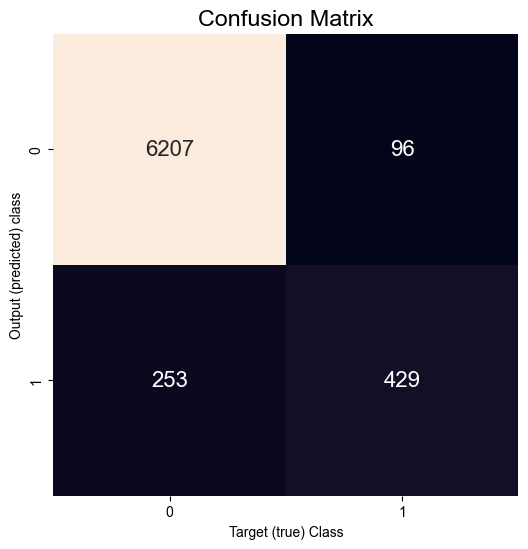

              precision    recall  f1-score   support

       licit      0.961     0.985     0.973      6303
     illicit      0.817     0.629     0.711       682

    accuracy                          0.950      6985
   macro avg      0.889     0.807     0.842      6985
weighted avg      0.947     0.950     0.947      6985

Test data fraud cases, percentage: 9.061416621608727 %


In [31]:
gcn_model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, 'gcn_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gcn_model, data_train)

# Confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[data_train.val_idx].detach().cpu().numpy(), y_test_preds[valid_idx])

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show()

print(classification_report(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                            y_test_preds[valid_idx],
                            target_names=['licit', 'illicit'], digits=3))


print(f"Test data fraud cases, percentage: {y_test_preds[data_train.test_idx].detach().cpu().numpy().sum() / len(data_train.y[data_train.test_idx]) *100} %")